In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image

# Set constants
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32
EPOCHS = 100


In [2]:
# Load and preprocess images
def load_images_from_folder(folder, is_grayscale=False):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)
        
        if is_grayscale:
            img = img.convert('L')  # Convert to grayscale
        else:
            img = img.convert('RGB')  # Convert to RGB
        
        img = img.resize((IMG_HEIGHT, IMG_WIDTH))  # Resize to (256, 256)
        img = np.array(img) / 127.5 - 1  # Normalize to [-1, 1]
        
        if is_grayscale:
            img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale
            
        images.append(img.astype(np.float32))
    
    return np.array(images)

# Load both black-and-white and colored images
bw_images = load_images_from_folder('/Users/abhirajkumar/Downloads/archive/blackclover/colored', is_grayscale=True)  # Update the path
color_images = load_images_from_folder('/Users/abhirajkumar/Downloads/archive/blackclover/colored', is_grayscale=False)  # Update the path

# Create TensorFlow Dataset
dataset_size = min(len(bw_images), len(color_images), 1000)  # Limit to 1000 images
bw_images = bw_images[:dataset_size]
color_images = color_images[:dataset_size]

dataset = tf.data.Dataset.from_tensor_slices((bw_images, color_images))
dataset = dataset.shuffle(buffer_size=1024).batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [3]:
# Define the Generator
def build_generator():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))  # Grayscale input
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    down1 = layers.LeakyReLU()(down1)

    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)

    down3 = layers.Conv2D(256, (4, 4), strides=2, padding='same')(down2)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)

    down4 = layers.Conv2D(512, (4, 4), strides=2, padding='same')(down3)
    down4 = layers.BatchNormalization()(down4)
    down4 = layers.LeakyReLU()(down4)

    up1 = layers.Conv2DTranspose(256, (4, 4), strides=2, padding='same')(down4)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.ReLU()(up1)

    up2 = layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same')(up1)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.ReLU()(up2)

    up3 = layers.Conv2DTranspose(64, (4, 4), strides=2, padding='same')(up2)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.ReLU()(up3)

    outputs = layers.Conv2DTranspose(3, (4, 4), strides=2, padding='same', activation='tanh')(up3)

    model = tf.keras.Model(inputs, outputs)
    return model

In [4]:
# Define the Discriminator
def build_discriminator():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 4))  # RGB input
    down1 = layers.Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    down1 = layers.LeakyReLU()(down1)

    down2 = layers.Conv2D(128, (4, 4), strides=2, padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)

    down3 = layers.Conv2D(256, (4, 4), strides=2, padding='same')(down2)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)

    flat = layers.Flatten()(down3)
    outputs = layers.Dense(1, activation='sigmoid')(flat)

    model = tf.keras.Model(inputs, outputs)
    return model

In [5]:
# Loss Functions
def generator_loss(fake_output, real_images, generated_images):
    l1_loss = tf.reduce_mean(tf.abs(real_images - generated_images))
    gan_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))
    return gan_loss + 100 * l1_loss  # Adjust weight as needed

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [6]:
# Instantiate models
generator = build_generator()
discriminator = build_discriminator()

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training step function
@tf.function
def train_step(bw_images, real_color_images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(bw_images, training=True)

        real_input = tf.concat([bw_images, real_color_images], axis=-1)  # Grayscale + real color
        fake_input = tf.concat([bw_images, generated_images], axis=-1)  # Grayscale + generated color

        real_output = discriminator(real_input, training=True)
        fake_output = discriminator(fake_input, training=True)

        gen_loss = generator_loss(fake_output, real_color_images, generated_images)
        disc_loss = discriminator_loss(real_output, fake_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

In [7]:
# Training Loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for bw_imgs, color_imgs in dataset:
            train_step(bw_imgs, color_imgs)
        print(f'Epoch {epoch + 1}/{epochs} completed.')

# Start Training
train(dataset, epochs=EPOCHS)

2024-10-05 09:42:13.741181: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/100 completed.


2024-10-05 09:44:19.383753: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/100 completed.
Epoch 3/100 completed.


2024-10-05 09:48:52.989084: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/100 completed.
Epoch 5/100 completed.
Epoch 6/100 completed.
Epoch 7/100 completed.


2024-10-05 09:58:10.645962: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8/100 completed.
Epoch 9/100 completed.
Epoch 10/100 completed.
Epoch 11/100 completed.
Epoch 12/100 completed.
Epoch 13/100 completed.
Epoch 14/100 completed.
Epoch 15/100 completed.


2024-10-05 10:16:38.297775: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 16/100 completed.
Epoch 17/100 completed.
Epoch 18/100 completed.
Epoch 19/100 completed.
Epoch 20/100 completed.
Epoch 21/100 completed.
Epoch 22/100 completed.
Epoch 23/100 completed.
Epoch 24/100 completed.
Epoch 25/100 completed.
Epoch 26/100 completed.
Epoch 27/100 completed.
Epoch 28/100 completed.
Epoch 29/100 completed.
Epoch 30/100 completed.
Epoch 31/100 completed.


2024-10-05 10:54:09.404404: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 32/100 completed.
Epoch 33/100 completed.
Epoch 34/100 completed.
Epoch 35/100 completed.
Epoch 36/100 completed.
Epoch 37/100 completed.
Epoch 38/100 completed.
Epoch 39/100 completed.
Epoch 40/100 completed.
Epoch 41/100 completed.
Epoch 42/100 completed.
Epoch 43/100 completed.
Epoch 44/100 completed.
Epoch 45/100 completed.
Epoch 46/100 completed.
Epoch 47/100 completed.
Epoch 48/100 completed.
Epoch 49/100 completed.
Epoch 50/100 completed.
Epoch 51/100 completed.
Epoch 52/100 completed.
Epoch 53/100 completed.
Epoch 54/100 completed.
Epoch 55/100 completed.
Epoch 56/100 completed.
Epoch 57/100 completed.
Epoch 58/100 completed.
Epoch 59/100 completed.
Epoch 60/100 completed.
Epoch 61/100 completed.
Epoch 62/100 completed.
Epoch 63/100 completed.


2024-10-05 12:06:13.546959: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 64/100 completed.
Epoch 65/100 completed.
Epoch 66/100 completed.
Epoch 67/100 completed.
Epoch 68/100 completed.
Epoch 69/100 completed.
Epoch 70/100 completed.
Epoch 71/100 completed.
Epoch 72/100 completed.
Epoch 73/100 completed.
Epoch 74/100 completed.
Epoch 75/100 completed.
Epoch 76/100 completed.
Epoch 77/100 completed.
Epoch 78/100 completed.
Epoch 79/100 completed.
Epoch 80/100 completed.
Epoch 81/100 completed.
Epoch 82/100 completed.
Epoch 83/100 completed.
Epoch 84/100 completed.
Epoch 85/100 completed.
Epoch 86/100 completed.
Epoch 87/100 completed.
Epoch 88/100 completed.
Epoch 89/100 completed.
Epoch 90/100 completed.
Epoch 91/100 completed.
Epoch 92/100 completed.
Epoch 93/100 completed.
Epoch 94/100 completed.
Epoch 95/100 completed.
Epoch 96/100 completed.
Epoch 97/100 completed.
Epoch 98/100 completed.
Epoch 99/100 completed.
Epoch 100/100 completed.


In [8]:
print("Shape of bw_image:", bw_images.shape)
print("Type of bw_image:", bw_images.dtype)

Shape of bw_image: (1000, 256, 256, 1)
Type of bw_image: float32


Shape of generated_image: (256, 256, 3)


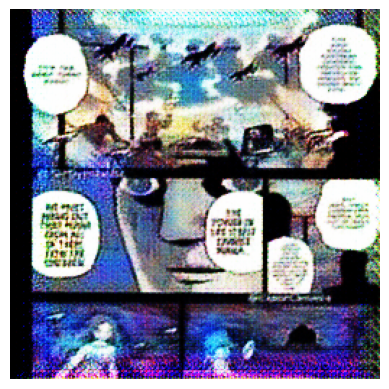

In [9]:
import matplotlib.pyplot as plt  # Fixed the import

# Function to display an image
def display_image(img):
    if img.ndim == 3 and img.shape[2] == 1:  # If the image is grayscale (HxWx1)
        img = img[:, :, 0]  # Remove the channel dimension for display
    img = (img + 1) / 2  # Convert from [-1, 1] to [0, 1] range
    img = np.clip(img, 0, 1)  # Clip values to ensure they are in [0, 1]
    plt.imshow(img, cmap='gray' if img.ndim == 2 else None)  # Display in grayscale if needed
    plt.axis('off')  # Hide axis
    plt.show()

# Function to test the colorization
def test_colorization(bw_image):
    bw_image = tf.convert_to_tensor(bw_image, dtype=tf.float32)  # Ensure the input is a tensor
    bw_image = tf.expand_dims(bw_image, 0)  # Add batch dimension, shape becomes (1, 256, 256, 1)
    
    # Generate the colorized image
    generated_image = generator(bw_image, training=False)[0]  # Get the first generated image
    print("Shape of generated_image:", generated_image.shape)  # Debugging
    
    display_image(generated_image)  # Display the generated image

# Test with a sample black-and-white image
sample_bw_image = bw_images[0]  # Get a sample B/W image from your dataset
test_colorization(sample_bw_image)  # Test the colorization on the sample image

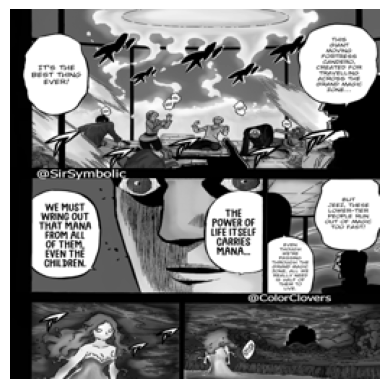

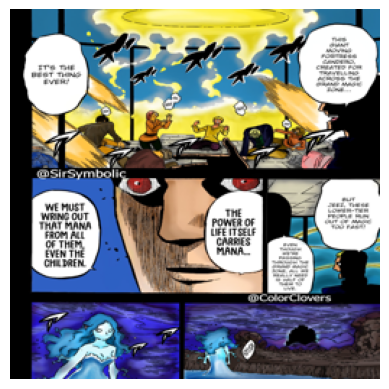

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def display_image(img):
    if img.ndim == 3 and img.shape[2] == 1:  # Check if the image is grayscale (HxWx1)
        img = img[:, :, 0]  # Remove the channel dimension for display
    img = (img + 1) / 2  # Scale pixel values from [-1, 1] to [0, 1]
    img = np.clip(img, 0, 1)  # Clip values to ensure they're in [0, 1]
    plt.imshow(img, cmap='gray' if img.ndim == 2 else None)  # Use gray colormap for grayscale images
    plt.axis('off')  # Hide axis
    plt.show()

# Assuming bw_images and color_images have been loaded correctly
# Show a sample black-and-white image
sample_bw_image = bw_images[0]  # Get the first B/W image
display_image(sample_bw_image)  # Display the grayscale image

# Show a sample colored image
sample_color_image = color_images[0]  # Get the first color image
display_image(sample_color_image)  # Display the color image

In [11]:

# Function to calculate Mean Squared Error (MSE)
def calculate_mse(real_image, generated_image):
    return tf.reduce_mean(tf.square(real_image - generated_image))

# Function to calculate Structural Similarity Index (SSIM)
def calculate_ssim(real_image, generated_image):
    real_image = (real_image + 1) / 2  # Convert from [-1, 1] to [0, 1] range
    generated_image = (generated_image + 1) / 2
    return tf.image.ssim(real_image, generated_image, max_val=1.0)

# Function to calculate Peak Signal-to-Noise Ratio (PSNR)
def calculate_psnr(real_image, generated_image):
    real_image = (real_image + 1) / 2  # Convert from [-1, 1] to [0, 1] range
    generated_image = (generated_image + 1) / 2
    return tf.image.psnr(real_image, generated_image, max_val=1.0)

# Function to evaluate the accuracy of the generator
def evaluate_accuracy(bw_images, color_images):
    total_mse = 0
    total_ssim = 0
    total_psnr = 0
    num_images = len(bw_images)
    
    for i in range(num_images):
        # Convert the black and white image to tensor and generate colorized image
        bw_image = tf.convert_to_tensor(bw_images[i], dtype=tf.float32)
        bw_image = tf.expand_dims(bw_image, 0)  # Add batch dimension
        
        # Generate the colorized image
        generated_image = generator(bw_image, training=False)[0]
        
        # Get the real color image
        real_color_image = tf.convert_to_tensor(color_images[i], dtype=tf.float32)

        # Calculate MSE, SSIM, and PSNR
        mse_value = calculate_mse(real_color_image, generated_image)
        ssim_value = calculate_ssim(real_color_image, generated_image)
        psnr_value = calculate_psnr(real_color_image, generated_image)
        
        # Accumulate the results
        total_mse += mse_value
        total_ssim += ssim_value
        total_psnr += psnr_value

    # Calculate the average for all images
    avg_mse = total_mse / num_images
    avg_ssim = total_ssim / num_images
    avg_psnr = total_psnr / num_images

    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f}")

# Test the accuracy on your dataset
evaluate_accuracy(bw_images, color_images)

Average MSE: 0.1113
Average SSIM: 0.5755
Average PSNR: 15.7260


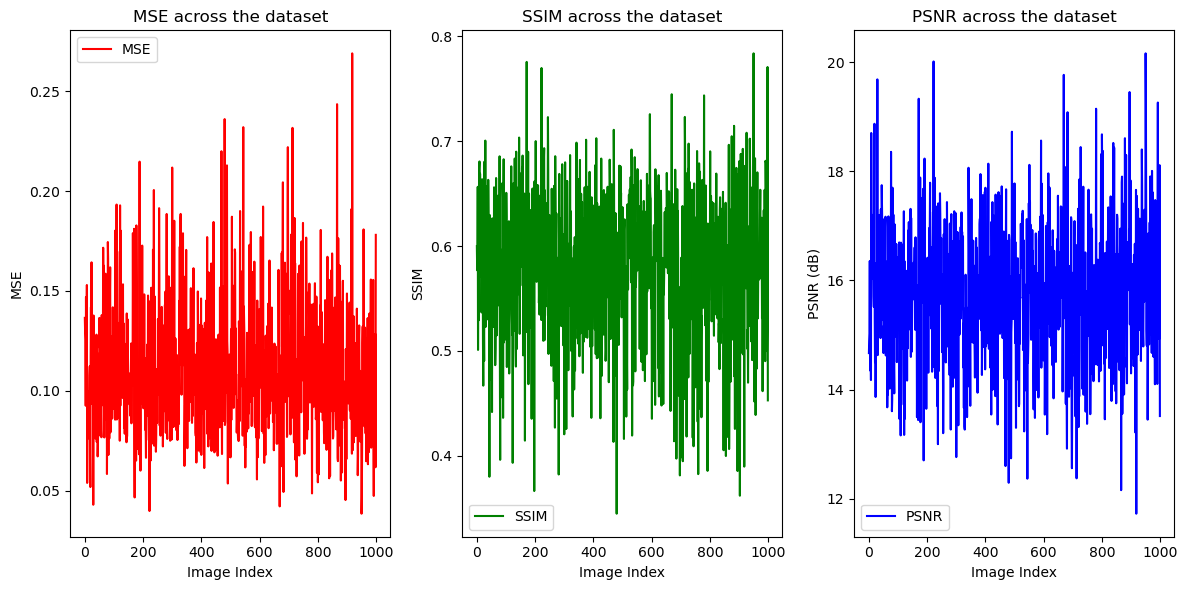

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Function to calculate Mean Squared Error (MSE)
def calculate_mse(real_image, generated_image):
    return tf.reduce_mean(tf.square(real_image - generated_image))

# Function to calculate Structural Similarity Index (SSIM)
def calculate_ssim(real_image, generated_image):
    real_image = (real_image + 1) / 2  # Convert from [-1, 1] to [0, 1] range
    generated_image = (generated_image + 1) / 2
    return tf.image.ssim(real_image, generated_image, max_val=1.0)

# Function to calculate Peak Signal-to-Noise Ratio (PSNR)
def calculate_psnr(real_image, generated_image):
    real_image = (real_image + 1) / 2  # Convert from [-1, 1] to [0, 1] range
    generated_image = (generated_image + 1) / 2
    return tf.image.psnr(real_image, generated_image, max_val=1.0)

# Function to evaluate the accuracy of the generator
def evaluate_accuracy(bw_images, color_images):
    mse_values = []
    ssim_values = []
    psnr_values = []
    num_images = len(bw_images)
    
    for i in range(num_images):
        # Convert the black and white image to tensor and generate colorized image
        bw_image = tf.convert_to_tensor(bw_images[i], dtype=tf.float32)
        bw_image = tf.expand_dims(bw_image, 0)  # Add batch dimension
        
        # Generate the colorized image
        generated_image = generator(bw_image, training=False)[0]
        
        # Get the real color image
        real_color_image = tf.convert_to_tensor(color_images[i], dtype=tf.float32)

        # Calculate MSE, SSIM, and PSNR
        mse_value = calculate_mse(real_color_image, generated_image)
        ssim_value = calculate_ssim(real_color_image, generated_image)
        psnr_value = calculate_psnr(real_color_image, generated_image)
        
        # Store the results for plotting
        mse_values.append(mse_value)
        ssim_values.append(ssim_value)
        psnr_values.append(psnr_value)

    # Convert lists to numpy arrays for easier handling
    mse_values = np.array(mse_values)
    ssim_values = np.array(ssim_values)
    psnr_values = np.array(psnr_values)

    # Plot the metrics
    plot_metrics(mse_values, ssim_values, psnr_values)

# Function to plot the accuracy metrics
def plot_metrics(mse_values, ssim_values, psnr_values):
    num_images = len(mse_values)
    x = np.arange(num_images)

    plt.figure(figsize=(12, 6))

    # Plot MSE
    plt.subplot(1, 3, 1)
    plt.plot(x, mse_values, label="MSE", color='r')
    plt.title("MSE across the dataset")
    plt.xlabel("Image Index")
    plt.ylabel("MSE")
    plt.legend()

    # Plot SSIM
    plt.subplot(1, 3, 2)
    plt.plot(x, ssim_values, label="SSIM", color='g')
    plt.title("SSIM across the dataset")
    plt.xlabel("Image Index")
    plt.ylabel("SSIM")
    plt.legend()

    # Plot PSNR
    plt.subplot(1, 3, 3)
    plt.plot(x, psnr_values, label="PSNR", color='b')
    plt.title("PSNR across the dataset")
    plt.xlabel("Image Index")
    plt.ylabel("PSNR (dB)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Test the accuracy on your dataset and visualize the results
evaluate_accuracy(bw_images, color_images)

In [14]:
# Save the model using the recommended Keras format
generator.save('colorization_generator_model.keras')